In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Lasso as ls
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale

In [47]:
# real estate data
data = {
    "train_data": "train.csv",
    "test_data": "test.csv"
}

url = "https://raw.githubusercontent.com/atn-iastate/STAT502_Kaggle/master/data/"

train_data = pd.read_csv("{}{}".format(url, data['train_data']), delimiter=",")
test_data = pd.read_csv("{}{}".format(url, data['test_data']), delimiter=",")

In [48]:
# necessary functions
def compute_rmsle(test, prediction):

    if test.shape[0] != prediction.shape[0]:
        raise Exception("Test data and prediction must have the same dimension")

    sum_log = np.sum((np.log(test + 1) - np.log(prediction + 1))**2)
    return np.sqrt(sum_log / test.shape[0])


In [49]:
# adding house_age
train_data['yr_sold'] = train_data['date'] // 10000
train_data['yr_sold'].head()
train_data['house_age'] = train_data['yr_sold'] - train_data['yr_built']
train_data['renovated'] = train_data['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)


In [50]:
# plit
train_data['zipcode_indicator'] = 1
pivot_train_data = train_data.pivot(columns = 'zipcode', values='zipcode_indicator')
for i in pivot_train_data.columns:
    pivot_train_data[i] = pivot_train_data[i].apply(lambda x: 0 if x != 1 else 1)
    train_data[i] = pivot_train_data[i]

train_data.drop(columns=98001)

,property,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,5467900070,20140502,342000.0,3,2.00,1930,11947,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7197300105,20140502,550000.0,4,2.50,1940,10500,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7525100520,20140502,335000.0,2,2.00,1350,2560,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2591720070,20140502,482000.0,4,2.50,2710,35868,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7739100015,20140502,463000.0,3,1.75,1710,7320,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8149600265,20150514,725000.0,4,1.75,1980,5850,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
9996,5057100110,20150514,479000.0,5,3.00,3223,6371,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,8562790720,20150514,750000.0,4,3.50,2630,3757,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,7923600250,20150515,450000.0,5,2.00,1870,7344,1.5,0,0,...,0,0,0,0,0,0,0,0,0,0


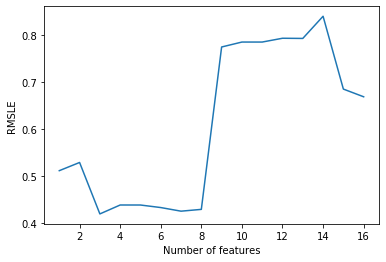

0.4198618096268227


In [51]:
# cross-validation for simple linear regression

cv_arr=[]

train_x = train_data.drop(columns = ['zipcode', 'property', 'date', 'price', 'yr_built', 'lat', 'long', 'yr_sold'])
train_y = train_data['price']

x = np.asarray(train_x)
y = np.asarray(train_y)

for i in range(1, 17, 1):

    rmsle = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x):
        reg = lr().fit(x[train_index, 0:i], y[train_index])
        y_predict = reg.predict(x[test_index, 0:i])
        y_predict = np.asarray([max(x, 0) for x in y_predict])
        rmsle.append(compute_rmsle(y[test_index], y_predict))

    cv_arr.append(np.mean(rmsle))

plt.plot(np.arange(1, 17, 1), cv_arr)
plt.ylabel('RMSLE')
plt.xlabel('Number of features')
plt.show()
print(np.min(cv_arr))

0.464973248459079


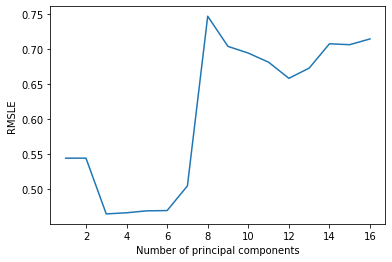

In [52]:
# cross-validation for simple linear regression with PCA

train_x = train_data.drop(columns = ['zipcode', 'property', 'date', 'price', 'yr_built', 'lat', 'long', 'yr_sold'])
train_y = train_data['price']
y = np.asarray(train_y)

vt = np.linalg.svd(train_x, full_matrices=False)[2]
v = np.transpose(vt)
kf = KFold(n_splits=10)
cv_arr = []

for i in range(1, 17, 1):
    x = np.asarray(train_x @ v[:, 0:i])

    rmsle = []
    for train_index, test_index in kf.split(x):
        reg = lr().fit(x[train_index, :], y[train_index])
        y_predict = reg.predict(x[test_index, :])
        y_predict = np.asarray([max(x, 0) for x in y_predict])
        rmsle.append(compute_rmsle(y[test_index], y_predict))
    cv_arr.append(np.mean(rmsle))

plt.ylabel('RMSLE')
plt.xlabel('Number of principal components')
plt.plot(np.arange(1, 17, 1), cv_arr)
print(np.min(cv_arr))

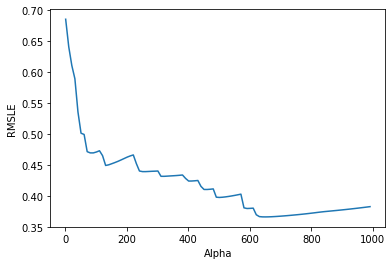

0.3659755289497386


In [62]:
# cross-validation for lasso regression

train_x = train_data.drop(columns = ['zipcode', 'property', 'date', 'price', 'yr_built', 'lat', 'long', 'yr_sold'])
train_y = train_data['price']

x = np.asarray(train_x)
y = np.asarray(train_y)

rmsle = []
kf = KFold(n_splits=10)
alpha_arr = []
cv_arr = []
for alpha in np.arange(1, 1000, 10):
    rmsle = []
    alpha_arr.append(alpha)
    
    for train_index, test_index in kf.split(x):

        reg = ls(alpha=alpha, normalize=True, tol=0.001, max_iter=100000).fit(x[train_index], y[train_index])
        y_predict_l2 = reg.predict(x[test_index])
        y_predict_l2 = np.asarray([max(x, 0) for x in y_predict_l2])
        rmsle.append(compute_rmsle(y[test_index], y_predict_l2))
        
    cv_arr.append(np.mean(np.asarray(rmsle)))
    
plt.plot(np.asarray(alpha_arr), np.asarray(cv_arr))
plt.ylabel('RMSLE')
plt.xlabel('Alpha')
plt.show()
print(np.min(cv_arr))

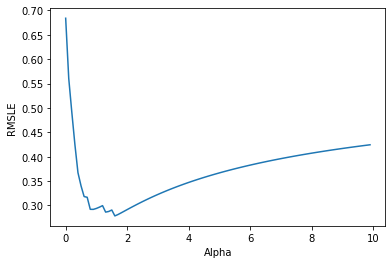

0.2785732995381648


In [59]:
# cross-validation for ridge regression

train_x = train_data.drop(columns = ['zipcode', 'property', 'date', 'price', 'yr_built', 'lat', 'long', 'yr_sold'])
train_y = train_data['price']

x = np.asarray(train_x)
y = np.asarray(train_y)

rmsle = []
kf = KFold(n_splits=10)
alpha_arr = []
cv_arr = []
for alpha in np.arange(0, 10, 0.1):
    rmsle = []
    alpha_arr.append(alpha)
    
    for train_index, test_index in kf.split(x):

        reg = Ridge(alpha=alpha, normalize=True, tol=0.001, max_iter=100000).fit(x[train_index], y[train_index])
        y_predict_l2 = reg.predict(x[test_index])
        y_predict_l2 = np.asarray([max(x, 0) for x in y_predict_l2])
        rmsle.append(compute_rmsle(y[test_index], y_predict_l2))
        
    cv_arr.append(np.mean(np.asarray(rmsle)))
    
plt.plot(np.asarray(alpha_arr), np.asarray(cv_arr))
plt.ylabel('RMSLE')
plt.xlabel('Alpha')
plt.show()
print(np.min(cv_arr))